In [ ]:
#!/usr/bin/env python3
"""
Initial Model Pipeline for Fossil Fuel Reduction Study
- Loads df_merged.csv
- Selects numeric features (drops obvious ID/text columns if present)
- Trains Logistic Regression (baseline) and RandomForest (nonlinear)
- Evaluates with train/test split + 5-fold CV (ROC-AUC)
- Computes VIF (if statsmodels available)
- Saves ROC curves and RF feature importances as PNGs
"""

import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
)

import matplotlib.pyplot as plt

DATA_PATH = Path("/df_merged.csv")  # expects to run in the folder that contains df_merged.csv

TARGET_COL = "Y_OUTCOME"
DROP_IF_PRESENT = ["Year", "State", "Area (SqMi)"]  # non-feature fields


def load_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"ERROR: File not found: {path.resolve()}", file=sys.stderr)
        sys.exit(1)
    df = pd.read_csv(path)
    return df


def prepare_features(df: pd.DataFrame):
    if TARGET_COL not in df.columns:
        print(f"ERROR: Target column '{TARGET_COL}' not found.", file=sys.stderr)
        sys.exit(1)

    # Drop obvious non-feature columns if present
    cols_to_drop = [c for c in DROP_IF_PRESENT if c in df.columns]
    df = df.drop(columns=cols_to_drop, errors="ignore")

    # Keep only numeric columns for modeling
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # Separate X and y
    y = numeric_df[TARGET_COL].astype(int)
    X = numeric_df.drop(columns=[TARGET_COL])

    # Track feature names
    feature_names = X.columns.tolist()

    return X, y, feature_names


def build_pipelines(random_state: int = 42):
    log_reg_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, penalty="l2", random_state=random_state)),
        ]
    )

    rf_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", RandomForestClassifier(n_estimators=300, random_state=random_state)),
        ]
    )

    return log_reg_pipe, rf_pipe


def evaluate_models(log_reg_pipe, rf_pipe, X, y, feature_names):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit models
    log_reg_pipe.fit(X_train, y_train)
    rf_pipe.fit(X_train, y_train)

    # Predictions
    y_pred_log = log_reg_pipe.predict(X_test)
    y_pred_rf = rf_pipe.predict(X_test)

    # Probabilities for ROC-AUC
    y_proba_log = log_reg_pipe.predict_proba(X_test)[:, 1]
    y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

    # Metrics
    print("\n=== Logistic Regression (Test) ===")
    print(classification_report(y_test, y_pred_log, digits=3))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_log), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

    print("\n=== Random Forest (Test) ===")
    print(classification_report(y_test, y_pred_rf, digits=3))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

    # 5-fold Stratified CV on full data (ROC-AUC)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_cv = cross_val_score(log_reg_pipe, X, y, cv=cv, scoring="roc_auc")
    rf_cv = cross_val_score(rf_pipe, X, y, cv=cv, scoring="roc_auc")

    print("\n=== Cross-Validation ROC-AUC (5-fold) ===")
    print(f"Logistic Regression: mean={log_cv.mean():.3f}, std={log_cv.std():.3f}, folds={np.round(log_cv,4)}")
    print(f"Random Forest:      mean={rf_cv.mean():.3f}, std={rf_cv.std():.3f}, folds={np.round(rf_cv,4)}")

    # ROC Curves (single figure, separate plots per guidelines)
    fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
    roc_auc_log = auc(fpr_log, tpr_log)

    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure()
    plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curves.png", dpi=150)
    plt.close()

    # RF Feature Importances (top 15)
    # To get importances, access the inner estimator
    rf_est = rf_pipe.named_steps["clf"]
    importances = getattr(rf_est, "feature_importances_", None)

    if importances is not None:
        imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        top = imp_series.head(15)

        plt.figure()
        top[::-1].plot(kind="barh")  # reverse for horizontal plot top-to-bottom
        plt.xlabel("Importance")
        plt.title("Random Forest Feature Importance (Top 15)")
        plt.tight_layout()
        plt.savefig("rf_feature_importance.png", dpi=150)
        plt.close()

        print("\nTop 15 RF Feature Importances:")
        print(top.to_string())
    else:
        print("\nRandom Forest does not expose feature_importances_.")

    return log_reg_pipe, rf_pipe, (X_train, X_test, y_train, y_test)


def compute_vif_on_train(pipeline, X_train, feature_names):
    """
    Computes VIF on transformed training features (after imputation & scaling).
    If statsmodels is unavailable, this step is skipped gracefully.
    """
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
    except Exception as e:
        print("\nVIF skipped (statsmodels not available).")
        return None

    # Extract the preprocessing steps up to (but not including) the classifier
    steps = pipeline.steps
    # Assume structure: [('imputer', ...), ('scaler', ...), ('clf', ...)]
    preprocess = Pipeline(steps[:-1])

    X_train_tx = preprocess.fit_transform(X_train)
    # Ensure it's a dense matrix
    if hasattr(X_train_tx, "toarray"):
        X_train_tx = X_train_tx.toarray()

    vif_data = pd.DataFrame({"Feature": feature_names})
    vif_vals = []
    for i in range(X_train_tx.shape[1]):
        try:
            vif_vals.append(variance_inflation_factor(X_train_tx, i))
        except Exception:
            vif_vals.append(np.nan)
    vif_data["VIF"] = vif_vals

    # Save to CSV
    vif_data.to_csv("vif_report.csv", index=False)
    print("\nVIF saved to vif_report.csv (first 10 rows):")
    print(vif_data.head(10).to_string(index=False))

    return vif_data


def main():
    df = load_data(DATA_PATH)
    X, y, feature_names = prepare_features(df)

    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    print("Class balance:", y.value_counts(normalize=True).round(3).to_dict())

    log_reg_pipe, rf_pipe = build_pipelines()
    log_reg_pipe, rf_pipe, splits = evaluate_models(log_reg_pipe, rf_pipe, X, y, feature_names)

    X_train, X_test, y_train, y_test = splits

    # Compute VIF on logistic regression preprocessing (imputer + scaler)
    compute_vif_on_train(log_reg_pipe, X_train, feature_names)

    print("\nArtifacts saved:")
    print(" - roc_curves.png")
    print(" - rf_feature_importance.png")
    print(" - vif_report.csv (if statsmodels available)")


if __name__ == "__main__":
    main()


Dataset shape: X=(1000, 15), y=(1000,)
Class balance: {0: 0.5, 1: 0.5}

=== Logistic Regression (Test) ===
              precision    recall  f1-score   support

           0      0.969     0.950     0.960       100
           1      0.951     0.970     0.960       100

    accuracy                          0.960       200
   macro avg      0.960     0.960     0.960       200
weighted avg      0.960     0.960     0.960       200

ROC-AUC: 0.9936
Confusion Matrix:
 [[95  5]
 [ 3 97]]

=== Random Forest (Test) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       100
           1      1.000     1.000     1.000       100

    accuracy                          1.000       200
   macro avg      1.000     1.000     1.000       200
weighted avg      1.000     1.000     1.000       200

ROC-AUC: 1.0
Confusion Matrix:
 [[100   0]
 [  0 100]]

=== Cross-Validation ROC-AUC (5-fold) ===
Logistic Regression: mean=0.995, std=0.003, folds=[0.996 

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


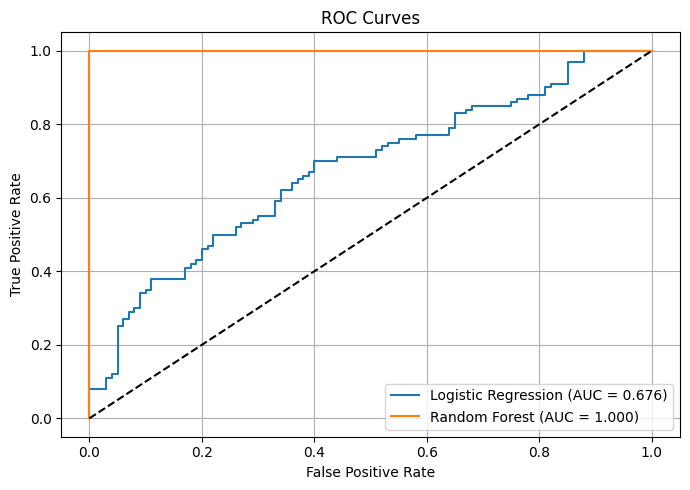

In [ ]:
#!/usr/bin/env python3
"""
Generate ROC Curve for Logistic Regression and Random Forest
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# === Load dataset ===
df = pd.read_csv("/df_merged.csv")

# === Feature selection ===
# Drop non-feature columns
drop_cols = ['Year', 'State', 'Area (SqMi)', 'Y_OUTCOME']
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df['Y_OUTCOME']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train models ===
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# === Predict probabilities ===
y_proba_log = log_reg.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# === Compute ROC curve points ===
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# === Plot ROC curves ===
plt.figure(figsize=(7, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)

# === Save & Show ===
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=150)
plt.show()
